In [1]:
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

if device_list != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_list))

Found GPU at: /device:GPU:0


## Reading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://github.com/aayush210789/Deception-Detection-on-Amazon-reviews-dataset/blob/master/amazon_reviews.txt

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import re

# Importing sklearn.metrics libraries
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Libraries required for hyper-parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [4]:
data = pd.read_csv("/content/drive/MyDrive/MS-Thesis backup/datasets/amazon_reviews.txt", delimiter = "\t")

In [5]:
data.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [6]:
data.shape

(21000, 9)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DOC_ID             21000 non-null  int64 
 1   LABEL              21000 non-null  object
 2   RATING             21000 non-null  int64 
 3   VERIFIED_PURCHASE  21000 non-null  object
 4   PRODUCT_CATEGORY   21000 non-null  object
 5   PRODUCT_ID         21000 non-null  object
 6   PRODUCT_TITLE      21000 non-null  object
 7   REVIEW_TITLE       21000 non-null  object
 8   REVIEW_TEXT        21000 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


## Data Cleaning

In [8]:
#Dropping unnecessary columns
data.drop(['DOC_ID','PRODUCT_ID'], axis=1, inplace=True) #The IDs in this case do not provide any useful information, hence dropping them

In [9]:
data.LABEL.value_counts()

__label1__    10500
__label2__    10500
Name: LABEL, dtype: int64

In [10]:
# Renaming the Label into numeric
data.loc[data["LABEL"] == "__label1__", "LABEL"] = '1'
data.loc[data["LABEL"] == "__label2__", "LABEL"] = '0'

In [11]:
data.head(1)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,4,N,PC,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL              21000 non-null  object
 1   RATING             21000 non-null  int64 
 2   VERIFIED_PURCHASE  21000 non-null  object
 3   PRODUCT_CATEGORY   21000 non-null  object
 4   PRODUCT_TITLE      21000 non-null  object
 5   REVIEW_TITLE       21000 non-null  object
 6   REVIEW_TEXT        21000 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [13]:
data['LABEL'] = data['LABEL'].astype(int)

###### duplicate records
perhaps we should decide on whether we should drop duplicated records in dataset first. This is a contentious issue among data scientists. One view is that duplicated records could result in bias in trained models, the other view is they reflect the distribution of the population of observations, and should be left as they are. In the ****** dataset there are a small portion of identical records, supposed to be job ads reposted. But among genuine and fraudulent job ads, the rates of duplication are more or the same, so apparently they can be safely dropped

In [14]:
# drop duplicate review_text)

## EDA

##### Univariate Analysis

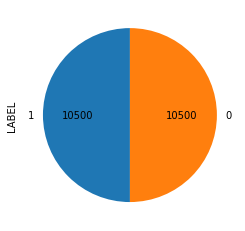

In [15]:
values=data['LABEL'].value_counts()
data.LABEL.value_counts().plot(kind='pie', startangle = 90,autopct= lambda x: '{:.0f}'.format(x*values.sum()/100));

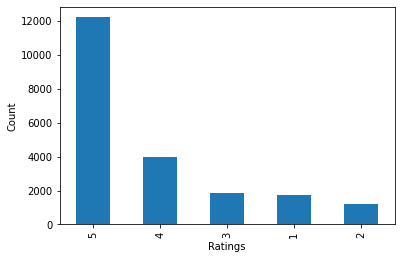

In [16]:
data.RATING.value_counts().plot(kind='bar')
plt.xlabel('Ratings')
plt.ylabel('Count');

In [17]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

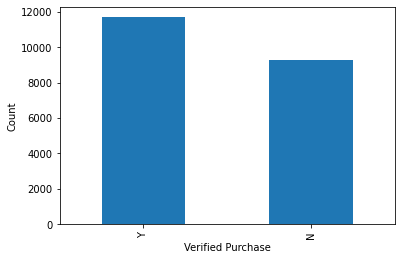

In [18]:
data['VERIFIED_PURCHASE'].value_counts().plot(kind='bar',)
plt.xlabel('Verified Purchase')
plt.ylabel('Count');

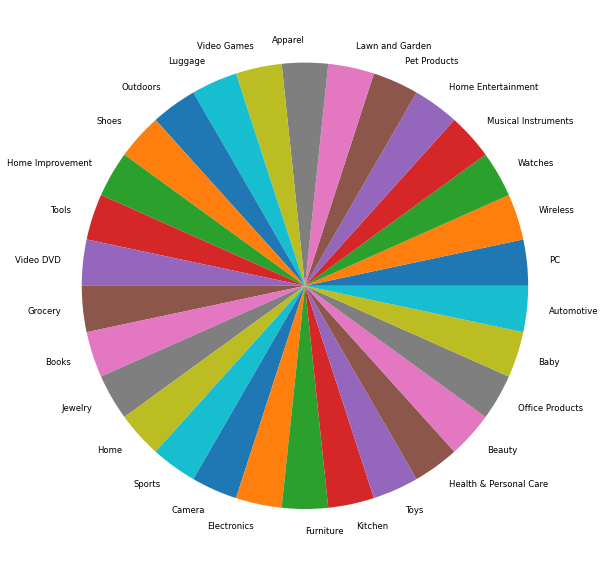

In [19]:
plt.figure(figsize=(10,15))
data.PRODUCT_CATEGORY.value_counts().plot(kind = 'pie', fontsize = 8.5)
plt.ylabel(' ');

##### Inference
All the categories have equal number of reviews

#### Bi-variate analysis

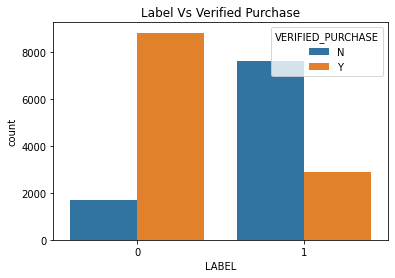

In [20]:
sns.countplot(x='LABEL', hue='VERIFIED_PURCHASE', data=data)
plt.title('Label Vs Verified Purchase');

##### Inference:
Most fake reviews are from customers who have not purchased the product on the website

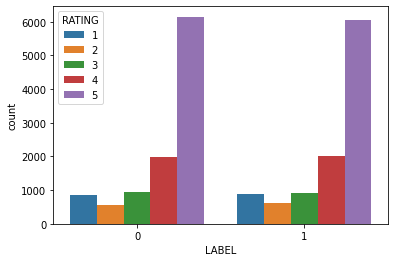

In [21]:
sns.countplot(x='LABEL', hue='RATING', data=data);

##### Inference:
- Ratings are divided equally for both the labels
- Both fake and real reviews have high/positive ratings

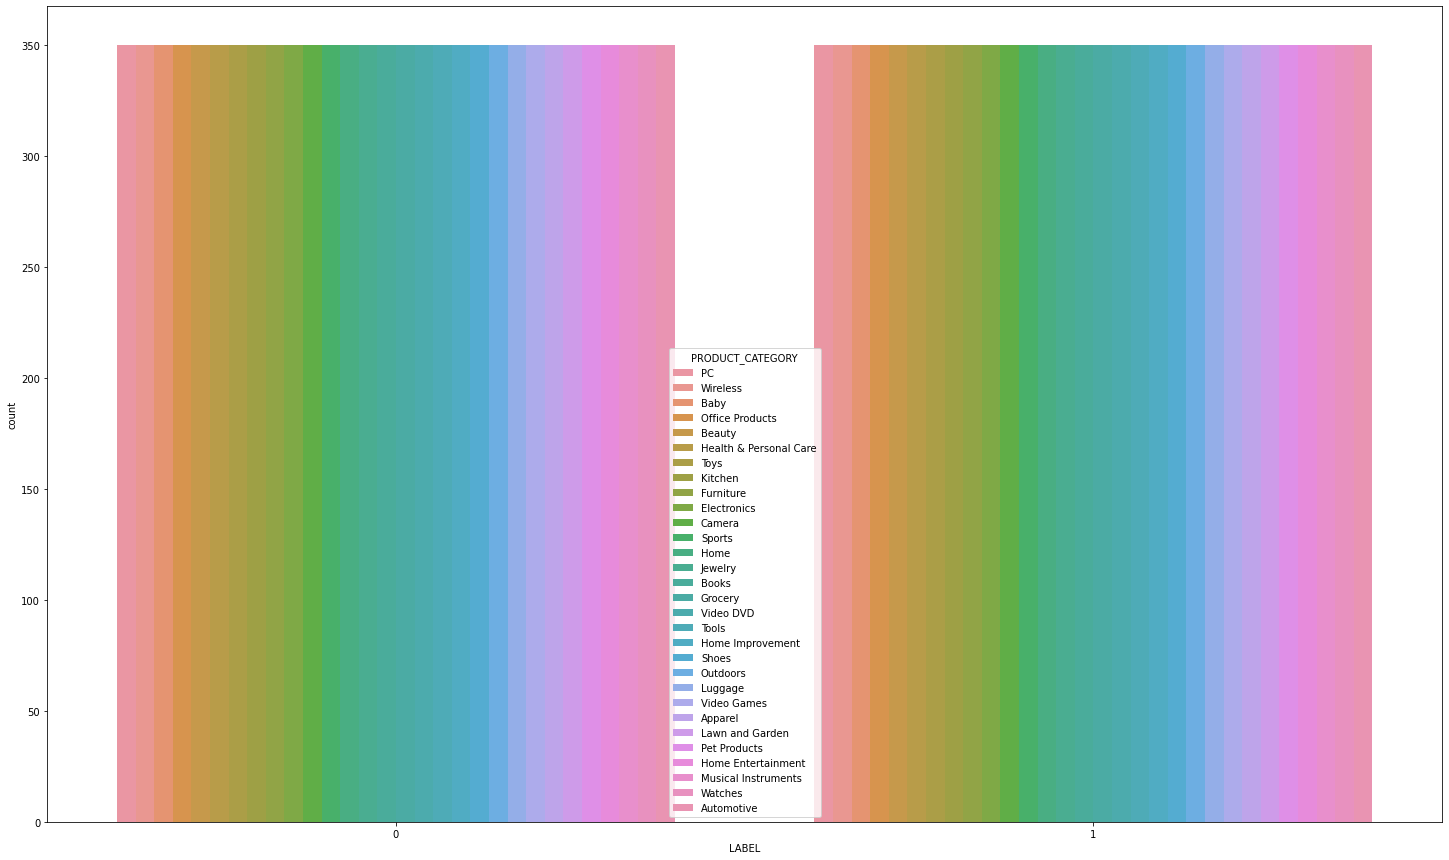

In [22]:
plt.figure(figsize=(25,15))
sns.countplot(x='LABEL', hue='PRODUCT_CATEGORY', data=data);

##### Inference
Equal number of product reviews for both the labels

## Analysis

#####  1. Visualising the sentiment of both fake and real reviews using TextBlob

In [23]:
from textblob import TextBlob
data['sentiment_score'] = data['REVIEW_TEXT'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [24]:
def label_column(x):
    if x == 0:
        return 'Neutral'
    elif x < 0:
        return 'Negative'
    else:
        return 'Positive'

In [25]:
data['sentiment_label']=data['sentiment_score'].apply(lambda x:label_column(x))
data.head()

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,sentiment_score,sentiment_label
0,1,4,N,PC,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",-0.300000,Negative
1,1,4,Y,Wireless,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,0.219226,Positive
2,1,3,N,Baby,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,0.347143,Positive
3,1,4,N,Office Products,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,-0.088542,Negative
4,1,4,N,Beauty,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,0.145833,Positive


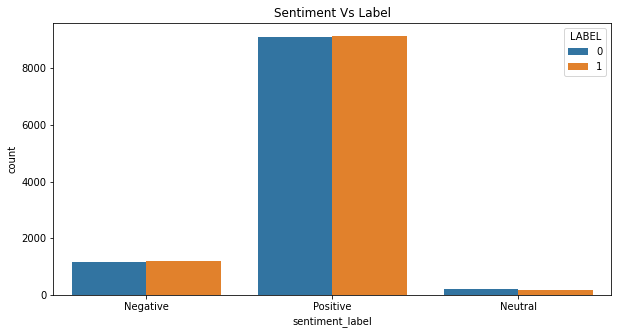

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='LABEL', data=data)
plt.title('Sentiment Vs Label');

##### Inference:
Most fake reviews have higher positive and negative sentiment indicating the reviewers either wrote very good things about a product or gave negative feedbacks

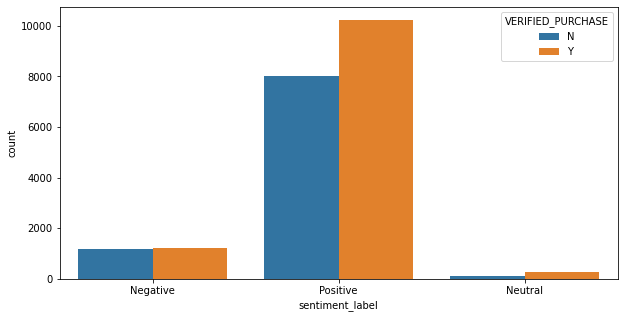

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='VERIFIED_PURCHASE', data=data);

##### Inference:
Customers who have purchased the product have mostly have positive sentiment score

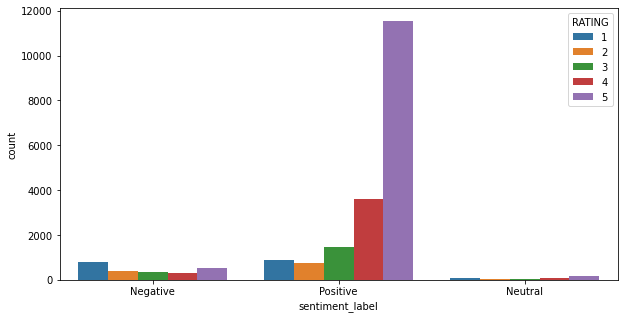

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='RATING', data=data);

##### Inference
Positive sentiment has highest rating as 5

#####  Checking the length of the reviews
- longer/shorter reviews have been verified?

In [29]:
data['review_length'] = data['REVIEW_TEXT'].map(len)

In [30]:
max(data['review_length'])

16188

In [31]:
min(data['review_length'])

98

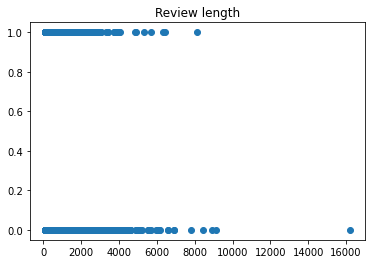

In [32]:
plt.scatter(x = 'review_length', y = 'LABEL', data=data)
plt.title('Review length');

##### Inference
All fake reviews have length less than 8k words

In [33]:
length = data.groupby('LABEL')['review_length'].mean()
length.head()

LABEL
0    428.064571
1    316.538857
Name: review_length, dtype: float64

##### Inference:
Fake reviews are shorter in length

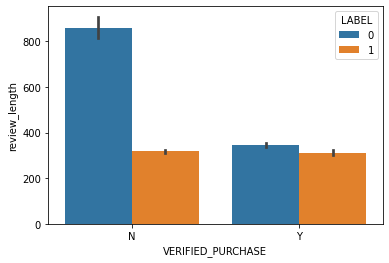

In [34]:
ax = sns.barplot(x="VERIFIED_PURCHASE", y="review_length", hue="LABEL", data=data)

##### Inference:
- Fake reviews are shorter in length in both cases in regardless of product being purchased or not
- Real reviews which have not been verified has the highest review length

##### References
- https://www.kaggle.com/code/crimsonred/fake-review-detection
- https://www.kaggle.com/code/amanai/amazon-fine-food-review-sentiment-analysis (length of the reviews)
- https://www.kaggle.com/code/shivamparab/amazon-electronic-reviews ( adding rating along with text reviews as features)
- https://www.kaggle.com/code/priscillabaah/fake-news-detection-embeddings-neural-networks (combine review text with review title)
- https://www.kaggle.com/code/bvsrohith/fake-news-detection-using-lstm-beginner-friendly
- https://www.kaggle.com/code/valmetisrinivas/nlp-sentiment-analysis-in-python (word-tokenize plotting or snippet)

In [35]:
def non_truncated(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

In [36]:
#non_truncated(data['REVIEW_TEXT'][20:30])

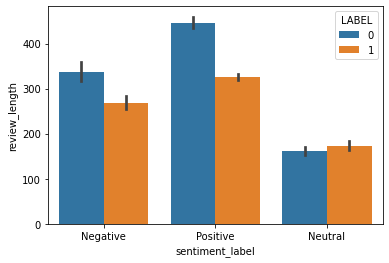

In [37]:
ax = sns.barplot(x="sentiment_label", y="review_length", hue="LABEL", data=data)

##### Inference:
Fake reviews with neutral tone have higher review length.
Real reviews have highest positive and negative sentiment


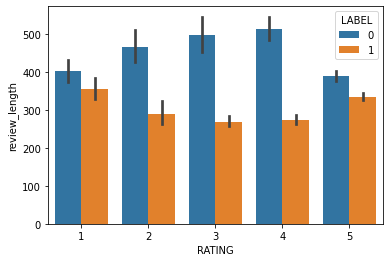

In [38]:
ax = sns.barplot(x="RATING", y="review_length", hue="LABEL", data=data)

## Text Pre-processing

- Removing stopwords,punctuations, emojis, HTML, contractions,non-alpha characters and numbers
- Convert all text to lower case
- Lemmatization

In [39]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
#Libraries for cleaning the text
import nltk
import contractions

# using nltk library for stopwords
from nltk.corpus import stopwords

#Lemmatization
from textblob import Word
from nltk.stem import WordNetLemmatizer

In [41]:
# remove emojis
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

In [42]:
# remove contractions
data['REVIEW_TEXT']=data['REVIEW_TEXT'].apply(lambda x:contractions.fix(x,slang=True))

In [43]:
# Lower casing and removing punctuations
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].str.replace('[^\w\s]','')

In [44]:
def preprocess(x):
    x=re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))',' ',x) # remove HTML
    x=re.sub('[^a-zA-Z]',' ',x) # remove non-alpha characters
    x=''.join([i for i in x if not i.isdigit()]) # remove numeric values
    return x

In [45]:
# applying preprocess function
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x: preprocess(x))

In [46]:
# remove stop words
#stop_words = set(stopwords.words('english'))
#data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x: ([word for word in x if word not in stop_words]))

In [47]:
  >>> import nltk
  >>> nltk.download('stopwords')
  >>> nltk.download('wordnet')
  nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
text = 'I will not go to school and work today'
stop_words = set(stopwords.words('english'))
sw = [word for word in text if word not in stop_words]

In [49]:
lem = " ".join([Word(word).lemmatize() for word in text.split() if word not in stop_words])

In [50]:
lem

'I go school work today'

In [51]:
data['REVIEW_TEXT'].head()

0    when least you think so this product will save...
1    lithium batteries are something new introduced...
2    i purchased this swing for my baby she is   mo...
3    i was looking for an inexpensive desk calcolat...
4    i only use it twice a week and the results are...
Name: REVIEW_TEXT, dtype: object

In [52]:
#Lemmatization
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split() if word not in stop_words]))
data['REVIEW_TEXT'].head()

0    least think product save day keep around case ...
1    lithium battery something new introduced marke...
2    purchased swing baby month pretty much grown l...
3    looking inexpensive desk calcolatur work every...
4    use twice week result great used teeth whiteni...
Name: REVIEW_TEXT, dtype: object

In [53]:
data.drop_duplicates(inplace=True)

In [54]:
data.shape

(21000, 10)

#### Analysis after cleaning the text

##### Total unique word count

In [55]:
list_words = []
for i in data['REVIEW_TEXT']:
    for j in i.split():
        list_words.append(j)
print(format(len(list_words)))

709498


In [56]:
total_unique_words = len(list(set(list_words)))
total_unique_words

38077

##### Unique word counts

In [57]:
data['count_unique_word']=data["REVIEW_TEXT"].apply(lambda x: len(set(str(x).split())))

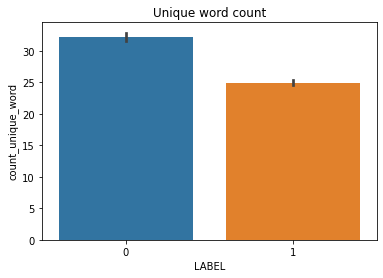

In [58]:
sns.barplot(y = data['count_unique_word'], x = data['LABEL'])
plt.title('Unique word count');

##### Inference:
Fake reviews have less unique words

In [59]:
def plot_word_frequency(words, top_n=15):
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    plot = sns.barplot(labels, counts)
    return plot

In [60]:
text = data['REVIEW_TEXT'].to_string()

In [61]:
text = text.replace('...','')

In [62]:
from nltk import FreqDist
plt_freq_words = text.split()

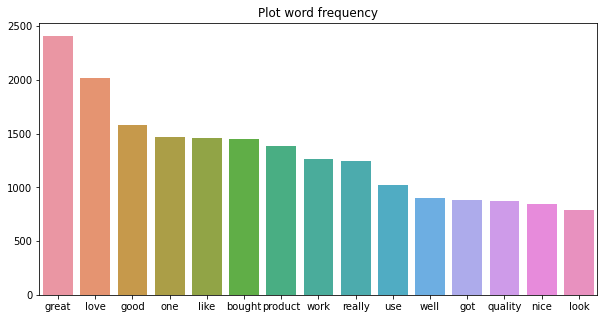

In [63]:
plt.figure(figsize=(10,5))
plot_word_frequency(plt_freq_words, 15)
plt.title('Plot word frequency');

In [64]:
>>> import nltk
>>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in data['REVIEW_TEXT']], nbins = 100)
fig.show()

#### Word cloud for real and fake reviews

In [66]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [67]:
fake_reviews = data[data['LABEL'] == 1]

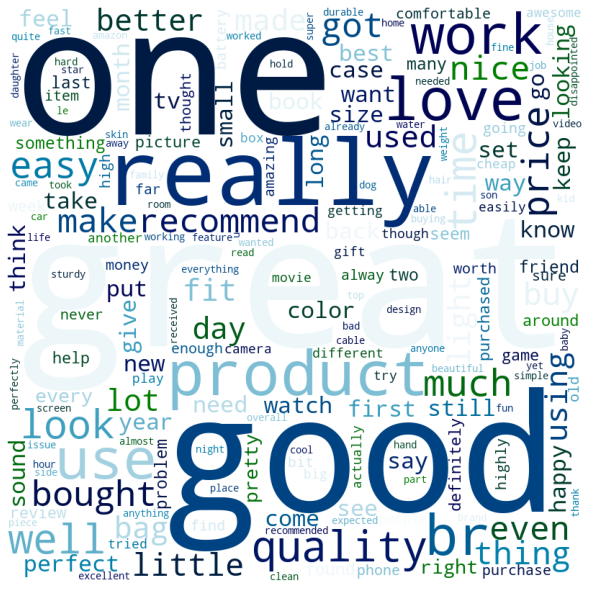

In [68]:
text_list = fake_reviews['REVIEW_TEXT'].to_list()
comment_words=''
stopwords = set(STOPWORDS)

for val in text_list:
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower().strip()
    
    comment_words +=" ".join(tokens)+' '
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap = 'ocean',
                stopwords = stopwords,
                min_font_size = 10,
                collocations=False).generate(comment_words)
                 
plt.figure(figsize = (8, 8), facecolor = None)
#! plt.title('Word Cloud')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [69]:
real_reviews = data[data['LABEL'] == 0]

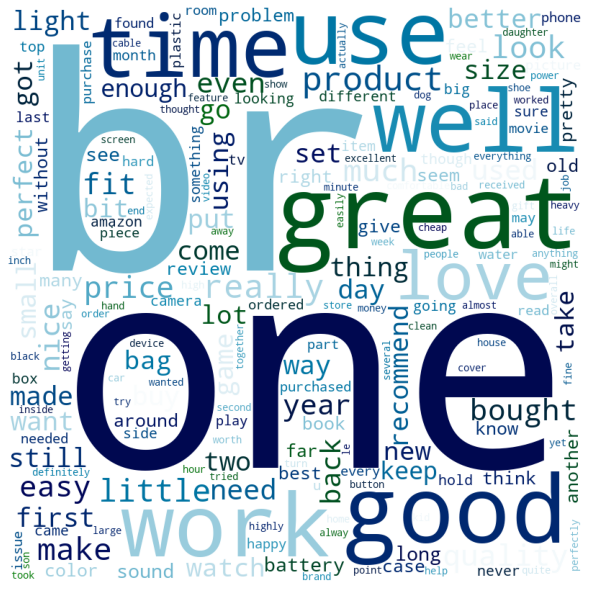

In [70]:
text_list = real_reviews['REVIEW_TEXT'].to_list()
comment_words=''
stopwords = set(STOPWORDS)

for val in text_list:
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower().strip()
    
    comment_words +=" ".join(tokens)+' '
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap = 'ocean',
                stopwords = stopwords,
                min_font_size = 10,
                collocations=False).generate(comment_words)
                 
plt.figure(figsize = (8, 8), facecolor = None)
#! plt.title('Word Cloud')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

##### TO DO
- can combine review title with review text
- plot word_tokenize

## Features and word embeddings for SVM and XGBoost

### Combining features

In [71]:
# Tokenization
from nltk.tokenize import word_tokenize
nltk.download('punkt')
maxlen = -1
for reviews in data['REVIEW_TEXT']:
    tokens = nltk.word_tokenize(reviews) #converts text to tokens (words)
    if (maxlen < len(tokens)):
        maxlen = len(tokens)
print(maxlen)
#tokenize = data['REVIEW_TEXT'].apply(lambda x: x.split())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1397


In [72]:
data['REVIEW_TEXT']

0        least think product save day keep around case ...
1        lithium battery something new introduced marke...
2        purchased swing baby month pretty much grown l...
3        looking inexpensive desk calcolatur work every...
4        use twice week result great used teeth whiteni...
                               ...                        
20995     bought work high arch use arch support heel high
20996    crocs one two brand shoe foot day work love cr...
20997    love moccasin fit like custom made mebr soft c...
20998    wish little durable got caught bolt crossing b...
20999    looking replacement beloved kso trek owned two...
Name: REVIEW_TEXT, Length: 21000, dtype: object

In [73]:
data['VERIFIED_PURCHASE'].replace('Y','YES', inplace=True)

In [74]:
data['VERIFIED_PURCHASE'].replace('N','NO',inplace=True)

In [75]:
data['VERIFIED_PURCHASE'].value_counts()

YES    11698
NO      9302
Name: VERIFIED_PURCHASE, dtype: int64

In [76]:
def rating(x):
    if x == 5:
        return 'Very Good'
    elif x == 4:
        return 'Good'
    elif x == 3:
        return 'Avg'
    elif x == 2:
        return 'Poor'
    else:
        return 'Bad'

In [77]:
data['RATING'] = data['RATING'].apply(lambda x:rating(x))

In [78]:
data['RATING'].value_counts()

Very Good    12210
Good          3973
Avg           1868
Bad           1757
Poor          1192
Name: RATING, dtype: int64

In [79]:
data['REVIEW_TEXT']

0        least think product save day keep around case ...
1        lithium battery something new introduced marke...
2        purchased swing baby month pretty much grown l...
3        looking inexpensive desk calcolatur work every...
4        use twice week result great used teeth whiteni...
                               ...                        
20995     bought work high arch use arch support heel high
20996    crocs one two brand shoe foot day work love cr...
20997    love moccasin fit like custom made mebr soft c...
20998    wish little durable got caught bolt crossing b...
20999    looking replacement beloved kso trek owned two...
Name: REVIEW_TEXT, Length: 21000, dtype: object

In [80]:
data['combined'] = data['REVIEW_TEXT'] + ' ' + data['RATING'] + ' ' + data['VERIFIED_PURCHASE'] + ' ' + data['PRODUCT_CATEGORY']

In [81]:
def non_truncated(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

In [82]:
data['combined'][1]

'lithium battery something new introduced market average developing cost relatively high stallion compromise quality provides u best low costbr many built technical assistant act like sensor particular fort battery keep phone charged work every voltage high voltage never risked Good YES Wireless'

In [83]:
data['combined'] = data['combined'].apply(lambda x : nltk.word_tokenize(x))

### Word Embeddings

### Word2Vec

In [84]:
import gensim
from gensim.models import Word2Vec

In [85]:
model_w2v = gensim.models.Word2Vec(data['combined'], size = 900, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=10, # Ignores all words with total frequency lower than 10.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 )

In [86]:
model_w2v.train(data['combined'], total_examples=len(data['combined']), epochs=30, report_delay=1)

(19700623, 23839680)

In [87]:
model_w2v.wv.most_similar(positive=["mobile"])

[('android', 0.36001378297805786),
 ('phone', 0.3357452154159546),
 ('htc', 0.3228479027748108),
 ('faulty', 0.32280686497688293),
 ('handsfree', 0.31081637740135193),
 ('protects', 0.3016102910041809),
 ('ooma', 0.2903088331222534),
 ('cell', 0.2892645597457886),
 ('fios', 0.28569918870925903),
 ('phonebr', 0.28512105345726013)]

In [88]:
len(model_w2v.wv['food'])

900

In [89]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [90]:
wordvec_arrays = np.zeros((len(data['combined']), 900)) 

In [91]:
#creating a matrix
for i in range(len(data['combined'])):
    wordvec_arrays[i,:] = word_vector(data['combined'][i], 900)

In [92]:
wordvec_arrays.shape

(21000, 900)

In [93]:
wordvec_arrays.shape[1]

900

In [94]:
embedding_size=wordvec_arrays.shape[1]

In [95]:
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(21000, 900)

In [96]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,-1.426798,-0.164655,0.552458,0.589617,0.206872,-0.187119,-0.838083,0.214781,0.516110,-0.105570,...,0.167558,-0.516273,-0.840985,-0.595737,-0.283988,-0.475852,-0.153610,-0.263777,-0.159601,0.662045
1,-0.245846,0.073075,0.368847,-0.057184,-0.089591,0.095685,-0.189353,-0.196744,0.208741,-0.142674,...,0.496438,-0.306332,-0.684218,0.386889,-0.177280,0.024856,0.195255,-0.058220,-0.152925,0.129545
2,-0.105917,-0.085843,0.497220,0.209364,-0.171504,-0.003527,-0.999689,-0.739442,1.114196,0.071605,...,0.579344,0.500973,-0.094152,0.202606,0.418625,0.143360,0.013337,0.181521,-0.423647,0.373830
3,-0.989601,-0.397139,0.118927,-0.046589,0.303519,0.052332,-0.263301,0.050079,0.453714,0.676082,...,0.016628,-0.579180,-0.090122,-0.051640,-0.115985,-0.267729,0.197557,-0.193631,0.078313,0.274992
4,0.098133,0.051118,0.486705,0.630387,-0.021902,1.049993,0.170618,0.077362,0.399956,0.050847,...,-0.408956,0.021919,0.101473,-0.076476,-0.350759,0.456520,-0.618171,-0.032217,-1.015173,0.514942


### Doc2Vec

In [ ]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

In [ ]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar")

In [ ]:
data['combined']

In [ ]:
# Tokenization
tokenize = data['REVIEW_TEXT'].apply(lambda x: x.split())

In [ ]:
tokenize

In [ ]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(data['combined'])]
tagged_data[:10]

##### 500 features

In [ ]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=900, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(tagged_data)])

model_d2v.train(tagged_data, total_examples= len(data['combined']), epochs=15)

In [ ]:
model_d2v.wv.most_similar('man')

In [ ]:
len(model_d2v['money'])

In [ ]:
docvec_arrays = np.zeros((len(data['combined']), 900)) 
for i in range(len(data)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,900))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

In [ ]:
docvec_df.head()

### Train test split

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, data['LABEL'], random_state=42, test_size=0.3, train_size=0.7)

In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

## SVM

In [102]:
from sklearn.svm import SVC

In [103]:
import time
start = time.process_time()

In [104]:
# Fit model on train data
model_raw_svm = SVC(C = 1, kernel = 'linear')
model_raw_svm.fit(X_train,y_train)

SVC(C=1, kernel='linear')

In [105]:
# your code here    
print(time.process_time() - start)

890.7899093169999


In [ ]:
y_pred = model_raw_svm.predict(X_test)

In [ ]:
print("ROC-AUC Score", roc_auc_score(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred))
print("SVM Accuracy: ",accuracy_score(y_test,y_pred))

ROC-AUC Score 0.801245572639555
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      3111
           1       0.85      0.74      0.79      3189

    accuracy                           0.80      6300
   macro avg       0.81      0.80      0.80      6300
weighted avg       0.81      0.80      0.80      6300

Confusion matrix:
 [[2686  425]
 [ 832 2357]]
SVM Accuracy:  0.8004761904761905


##### Inference:

SVM Model's accuracy is at 80% with default hyper-parameters setting. Next, tuning the hyper-parameters using gridsearchCV

#### Hyper-parameter tuning on SVM

In [ ]:
# Parameters
hyper_params = {
    "C": [0.001,0.01,0.1],
    "kernel":['linear','sigmoid','rbf']
}

# Tune using gridsearchCV
model_svm_h = GridSearchCV(estimator = SVC(),
                           param_grid = hyper_params,
                          scoring = 'roc_auc',
                            cv = 10,
                          n_jobs=-1,
                          verbose=1)

In [ ]:
model_svm_h.fit(X_train,y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1],
                         'kernel': ['linear', 'sigmoid', 'rbf']},
             scoring='roc_auc', verbose=1)

In [ ]:
print("SVM Model's Best AUC: ",model_svm_h.best_score_)
print("SVM Model's Best Hyper-parameters: ",model_svm_h.best_params_)

SVM Model's Best AUC:  0.8596809895060691
SVM Model's Best Hyper-parameters:  {'C': 0.1, 'kernel': 'linear'}


In [107]:
# Passing the best parameteres
model_svm_tuned = SVC(C= 0.1, kernel = 'linear')

In [108]:
start = time.process_time()

In [109]:
# Predicting on test data
model_svm_tuned.fit(X_train,y_train)
y_pred_svmtuned = model_svm_tuned.predict(X_test)

In [110]:
# your code here    
print(time.process_time() - start)

198.39041609899982


In [ ]:
# Evaluation Metric
print("ROC-AUC Score", roc_auc_score(y_test,y_pred_svmtuned))
print("Classification Report:\n", classification_report(y_test, y_pred_svmtuned))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred_svmtuned))
print("SVM Accuracy: ",accuracy_score(y_test,y_pred_svmtuned))

ROC-AUC Score 0.7961069164645949
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      3111
           1       0.85      0.73      0.78      3189

    accuracy                           0.80      6300
   macro avg       0.80      0.80      0.79      6300
weighted avg       0.80      0.80      0.79      6300

Confusion matrix:
 [[2695  416]
 [ 874 2315]]
SVM Accuracy:  0.7952380952380952


#### Results of SVM:
- Accuracy : 80%
- Precision : 85%
- Recall : 73%
- F1-Score : 78%

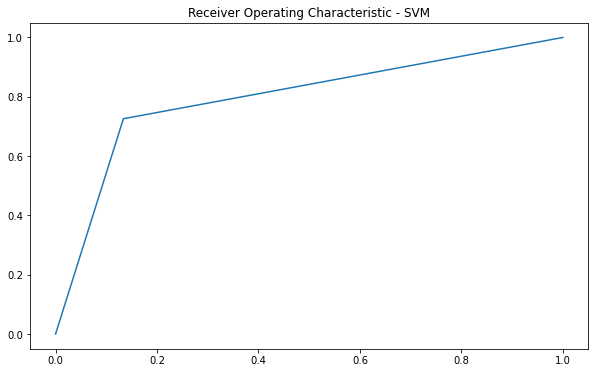

In [ ]:
# Plot ROC curve
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_svmtuned)
roc_auc = roc_auc_score(y_test, y_pred_svmtuned)
plt.title('Receiver Operating Characteristic - SVM')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate, roc_auc)
plt.show()

In [ ]:
# Passing the best parameteres
model_svm_tuned4 = SVC(C= 1, kernel = 'linear')

In [ ]:
# Predicting on test data
model_svm_tuned4.fit(X_train,y_train)
y_pred_svmtuned4 = model_svm_tuned4.predict(X_test)

In [ ]:
# Evaluation Metric
print("ROC-AUC Score", roc_auc_score(y_test,y_pred_svmtuned4))
print("Classification Report:\n", classification_report(y_test, y_pred_svmtuned4))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred_svmtuned4))
print("SVM Accuracy: ",accuracy_score(y_test,y_pred_svmtuned4))

ROC-AUC Score 0.53040632381139
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.47      0.50      3111
           1       0.53      0.59      0.56      3189

    accuracy                           0.53      6300
   macro avg       0.53      0.53      0.53      6300
weighted avg       0.53      0.53      0.53      6300

Confusion matrix:
 [[1473 1638]
 [1316 1873]]
SVM Accuracy:  0.5311111111111111


## XGBoost

In [100]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
#Default parameters
model_raw_xgb = XGBClassifier()
model_raw_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# Predict on the test data
y_pred = model_raw_xgb.predict(X_test)

In [ ]:
y_test = le.fit_transform(y_test)
y_pred = le.fit_transform(y_pred)

In [ ]:
# Evaluation Metric
print("ROC-AUC Score", roc_auc_score(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred))
print("XGBoost Accuracy: ",accuracy_score(y_test,y_pred))

ROC-AUC Score 0.731282164794422
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.73      3111
           1       0.74      0.72      0.73      3189

    accuracy                           0.73      6300
   macro avg       0.73      0.73      0.73      6300
weighted avg       0.73      0.73      0.73      6300

Confusion matrix:
 [[2318  793]
 [ 901 2288]]
XGBoost Accuracy:  0.7311111111111112


##### Inference:
Accuracy of XGBoost is at 73% which lower than that of SVM with default parameters. Let's further perform hyper-tuning on XGBoost

#### Hyper-parameter tuning on XGBoost

In [ ]:
hyper_params = {'learning_rate': [0.2,0.4, 0.6], 
             'subsample': [0.2, 0.3, 0.4],
               'max_depth': [2,5,7,10],
               'n_estimators' : [10, 30, 50],
               'eval_metric' :['auc']}          


# set up GridSearchCV()
model_xgb_h = GridSearchCV(estimator = XGBClassifier(), 
                        param_grid = hyper_params, 
                        scoring= 'roc_auc', 
                        cv = 4, 
                        verbose = 1,
                        )      

In [ ]:
# Fit the model
model_xgb_h.fit(X_train,y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [ ]:
print("XGBoost Model's Best AUC: ",model_xgb_h.best_score_)
print("XGBoost Model's Best Hyper-parameters: ",model_xgb_h.best_params_)

XGBoost Model's Best AUC:  0.5755030239022777
XGBoost Model's Best Hyper-parameters:  {'eval_metric': 'auc', 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.4}


#### Passing a range of parameters to see the performance

In [101]:
model_xgb_tuned1 = XGBClassifier(eval_metric = 'auc', learning_rate = 0.2, max_depth = 6, n_estimators = 100, subsample = 1)

In [102]:
import time
start = time.process_time()

In [103]:
# Fit the tuned model and Predicting on test data
model_xgb_tuned1.fit(X_train,y_train)
y_pred_boost_tuned1 = model_xgb_tuned1.predict(X_test)

In [104]:
# your code here    
print(time.process_time() - start)

161.445464274


In [ ]:
# Evaluation Metric
print("ROC-AUC Score", roc_auc_score(y_test,y_pred_boost_tuned1))
print("Classification Report:\n", classification_report(y_test, y_pred_boost_tuned1))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_pred_boost_tuned1))
print("XGBoost Accuracy: ",accuracy_score(y_test,y_pred_boost_tuned1))

ROC-AUC Score 0.7344297372265379
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.73      3111
           1       0.74      0.72      0.73      3189

    accuracy                           0.73      6300
   macro avg       0.73      0.73      0.73      6300
weighted avg       0.73      0.73      0.73      6300

Confusion matrix:
 [[2321  790]
 [ 884 2305]]
XGBoost Accuracy:  0.7342857142857143


#### Results of XGBoost:
- Accuracy : 75%
- Precision : 74%
- Recall : 72%
- F1-Score : 73%

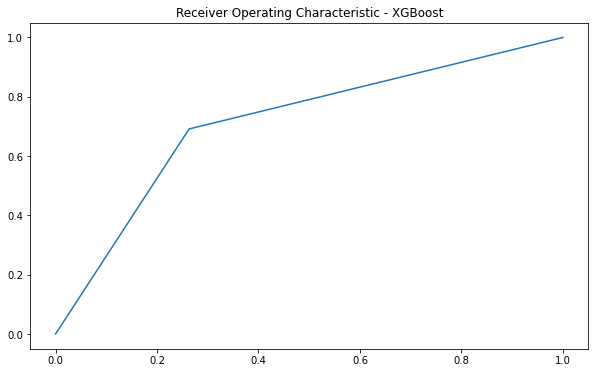

In [ ]:
# Plot ROC curve
plt.figure(figsize=(10,6))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_boost_tuned)
roc_auc = roc_auc_score(y_test, y_pred_boost_tuned)
plt.title('Receiver Operating Characteristic - XGBoost')
plt.ylabel="True Positive Rate"
plt.xlabel="False Positive Rate"
plt.plot(false_positive_rate, true_positive_rate, roc_auc)
plt.show()

## Bi-LSTM

In [ ]:
#!pip install keras
#!pip install tensorflow

In [ ]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

### Tokenisation and Padding

In [ ]:
# train test spolit for Bi-LSTM
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(data['REVIEW_TEXT'],data['LABEL'], test_size = 0.3, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_l1 = to_categorical(np.asarray(y_train_l))

In [ ]:
y_train_l1.shape

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= total_unique_words)
tokenizer.fit_on_texts(X_train_l) #It creates vocabulary index ("word_index") based on word frequency
train_sequences = tokenizer.texts_to_sequences(X_train_l) # Replace each word in text with corresponding integer value from "word_index"
test_sequences = tokenizer.texts_to_sequences(X_test_l)

In [ ]:
train_sequences[1]

In [ ]:
print('Length of train sequences:',len(train_sequences))
print('Length of test sequences:',len(test_sequences))

In [ ]:
pad_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen = 1397, padding = 'post', truncating= 'post')
pad_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen= 1397, padding = 'post', truncating= 'post')

In [ ]:
pad_train[1]

In [ ]:
pad_test[1]

### Model Building

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(total_unique_words, output_dim = 100), #Embedding Layer
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)), #Bi-directional LSTM
#Dense layer
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(64, activation = 'relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(2, activation = 'sigmoid')]) # binary classification (0\1)

#X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(embedding_layer)
#X = tf.keras.layers.GlobalMaxPool1D()(X)
#X = tf.keras.layers.Dense(128, activation='relu')(X)
#X = tf.keras.layers.Dropout(0.3)(X)
#X = tf.keras.layers.Dense(2, activation='sigmoid')(X)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['acc'])

In [ ]:
model.summary()

In [ ]:
y_train_l1.shape

In [ ]:
model.fit(pad_train, y_train_l1, batch_size= 32, validation_split = 0.3, epochs= 5)

## Bi-LSTM : Combined features

In [ ]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

### Tokenisation and Padding

In [ ]:
# train test spolit for Bi-LSTM
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(data['combined'],data['LABEL'], test_size = 0.3, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_l1 = to_categorical(np.asarray(y_train_l))

In [ ]:
y_train_l1.shape

(14700, 2)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= total_unique_words)
tokenizer.fit_on_texts(X_train_l) #It creates vocabulary index ("word_index") based on word frequency
train_sequences = tokenizer.texts_to_sequences(X_train_l) # Replace each word in text with corresponding integer value from "word_index"
test_sequences = tokenizer.texts_to_sequences(X_test_l)

In [ ]:
train_sequences[1]

[27,
 950,
 70,
 621,
 974,
 164,
 576,
 1028,
 1397,
 662,
 3817,
 10768,
 154,
 122,
 34,
 866,
 390,
 265,
 88,
 830,
 104,
 4245,
 444,
 122,
 34,
 5554,
 1502,
 265,
 89,
 75,
 5555,
 351,
 2658,
 754,
 734,
 137,
 40,
 3,
 164]

In [ ]:
print('Length of train sequences:',len(train_sequences))
print('Length of test sequences:',len(test_sequences))

Length of train sequences: 14700
Length of test sequences: 6300


In [ ]:
pad_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen = 1397, padding = 'post', truncating= 'post')
pad_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen= 1397, padding = 'post', truncating= 'post')

In [ ]:
pad_train[1]

array([ 27, 950,  70, ...,   0,   0,   0], dtype=int32)

In [ ]:
pad_test[1]

array([ 567, 1254,   43, ...,    0,    0,    0], dtype=int32)

### Model Building

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(total_unique_words, output_dim = 100), #Embedding Layer
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)), #Bi-directional LSTM
#Dense layer
tf.keras.layers.Dense(256, activation = 'relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(64, activation = 'relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation = 'softmax')]) # binary classification (0\1)

#X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(embedding_layer)
#X = tf.keras.layers.GlobalMaxPool1D()(X)
#X = tf.keras.layers.Dense(128, activation='relu')(X)
#X = tf.keras.layers.Dropout(0.3)(X)
#X = tf.keras.layers.Dense(2, activation='sigmoid')(X)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3807700   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             2510848   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
y_train_l1.shape

(14700, 2)

In [ ]:
model.fit(pad_train, y_train_l1, batch_size= 32, validation_split = 0.3, epochs= 5)

Epoch 1/5
322/322 [==============================] - 159s 469ms/step - loss: 0.7006 - acc: 0.4989 - val_loss: 0.6935 - val_acc: 0.4864
Epoch 2/5
322/322 [==============================] - 151s 468ms/step - loss: 0.6937 - acc: 0.5006 - val_loss: 0.6933 - val_acc: 0.4864
Epoch 3/5
322/322 [==============================] - 151s 468ms/step - loss: 0.6936 - acc: 0.5008 - val_loss: 0.6933 - val_acc: 0.4864
Epoch 4/5
322/322 [==============================] - 150s 467ms/step - loss: 0.6935 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.4864
Epoch 5/5
322/322 [==============================] - 150s 467ms/step - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4864


## Bi-LSTM with word2vec embeddings + combined features

In [71]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

### Combining features for Bi-LSTM

In [72]:
data['REVIEW_TEXT']

0        least think product save day keep around case ...
1        lithium battery something new introduced marke...
2        purchased swing baby month pretty much grown l...
3        looking inexpensive desk calcolatur work every...
4        use twice week result great used teeth whiteni...
                               ...                        
20995     bought work high arch use arch support heel high
20996    crocs one two brand shoe foot day work love cr...
20997    love moccasin fit like custom made mebr soft c...
20998    wish little durable got caught bolt crossing b...
20999    looking replacement beloved kso trek owned two...
Name: REVIEW_TEXT, Length: 21000, dtype: object

In [73]:
data['VERIFIED_PURCHASE'].replace('Y','YES', inplace=True)

In [74]:
data['VERIFIED_PURCHASE'].replace('N','NO',inplace=True)

In [75]:
data['VERIFIED_PURCHASE'].value_counts()

YES    11698
NO      9302
Name: VERIFIED_PURCHASE, dtype: int64

In [76]:
def rating(x):
    if x == 5:
        return 'Very Good'
    elif x == 4:
        return 'Good'
    elif x == 3:
        return 'Avg'
    elif x == 2:
        return 'Poor'
    else:
        return 'Bad'

In [77]:
data['RATING'] = data['RATING'].apply(lambda x:rating(x))

In [78]:
data['RATING'].value_counts()

Very Good    12210
Good          3973
Avg           1868
Bad           1757
Poor          1192
Name: RATING, dtype: int64

In [79]:
data['REVIEW_TEXT']

0        least think product save day keep around case ...
1        lithium battery something new introduced marke...
2        purchased swing baby month pretty much grown l...
3        looking inexpensive desk calcolatur work every...
4        use twice week result great used teeth whiteni...
                               ...                        
20995     bought work high arch use arch support heel high
20996    crocs one two brand shoe foot day work love cr...
20997    love moccasin fit like custom made mebr soft c...
20998    wish little durable got caught bolt crossing b...
20999    looking replacement beloved kso trek owned two...
Name: REVIEW_TEXT, Length: 21000, dtype: object

In [80]:
data['combined'] = data['REVIEW_TEXT'] + ' ' + data['RATING'] + ' ' + data['VERIFIED_PURCHASE'] + ' ' + data['PRODUCT_CATEGORY']

In [81]:
def non_truncated(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

In [82]:
data['combined'][1]

'lithium battery something new introduced market average developing cost relatively high stallion compromise quality provides u best low costbr many built technical assistant act like sensor particular fort battery keep phone charged work every voltage high voltage never risked Good YES Wireless'

### Train test split

In [83]:
# train test spolit for Bi-LSTM
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(data['combined'],data['LABEL'], test_size = 0.3, random_state = 42)

### Tokenisation and Padding

In [84]:
X_train_l

16485    flag arrived time appears good quality star em...
19237    bought become new medium center pc window horr...
15032    always easy find grocery large quantity nice c...
7781     fact could order device program minute stick u...
18376    chance use crossbow yet seems sturdy enough wa...
                               ...                        
11284    started using powder making capsule form use s...
11964    get pay knew going professional set even one u...
5390     asinb h jab yellow double stainless steel twis...
860      product exactly would expected perfect intende...
15795    nice watch band broke month also back clear di...
Name: combined, Length: 14700, dtype: object

In [85]:
from tensorflow.keras.utils import to_categorical
y_train_l1 = to_categorical(np.asarray(y_train_l))

In [86]:
y_train_l1.shape

(14700, 2)

In [87]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= total_unique_words)
tokenizer.fit_on_texts(X_train_l) #It creates vocabulary index ("word_index") based on word frequency
train_sequences = tokenizer.texts_to_sequences(X_train_l) # Replace each word in text with corresponding integer value from "word_index"
test_sequences = tokenizer.texts_to_sequences(X_test_l)
# Setting a vocabulary size that we will specify in the neural network
#vocab_size = len(tokenizer.word_index) + 1
# The t.word_index contains each unique word in our text and an integer assigned to it
#print(vocab_size)

In [88]:
train_sequences[1]
test_sequences[1]

[565,
 1252,
 43,
 214,
 65,
 2252,
 10629,
 86,
 651,
 10629,
 565,
 9,
 2551,
 848,
 1252,
 86,
 43,
 214,
 327,
 8321,
 1643,
 2623,
 20,
 705,
 787,
 695,
 1009,
 3040,
 906,
 353,
 72,
 6664,
 214,
 86,
 33,
 9,
 13,
 3454,
 642,
 1,
 3,
 171]

In [89]:
print('Length of train sequences:',len(train_sequences))
print('Length of test sequences:',len(test_sequences))

Length of train sequences: 14700
Length of test sequences: 6300


In [90]:
pad_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen = 1397, padding = 'post', truncating= 'post')
pad_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen= 1397, padding = 'post', truncating= 'post')

In [91]:
pad_train[1]

array([ 27, 948,  69, ...,   0,   0,   0], dtype=int32)

In [92]:
pad_test[1]

array([ 565, 1252,   43, ...,    0,    0,    0], dtype=int32)

### Word2Vec

In [93]:
import gensim
from gensim.models import Word2Vec

In [94]:
data['combined-tokens'] = data['combined'].apply(lambda x : nltk.word_tokenize(x))

In [95]:
model_w2v = gensim.models.Word2Vec(data['combined-tokens'], size = 900, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=10, # Ignores all words with total frequency lower than 10.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 )

In [96]:
model_w2v.train(data['combined-tokens'], total_examples=len(data['combined-tokens']), epochs=30, report_delay=1)

(19697846, 23839680)

In [97]:
model_w2v.wv.most_similar(positive=["man"])

[('police', 0.288457989692688),
 ('married', 0.2704641819000244),
 ('men', 0.26204144954681396),
 ('development', 0.2584663927555084),
 ('roy', 0.23588672280311584),
 ('conflict', 0.23076868057250977),
 ('simon', 0.22291305661201477),
 ('bob', 0.22031232714653015),
 ('survival', 0.21874471008777618),
 ('sue', 0.2176666259765625)]

In [98]:
len(model_w2v.wv['food'])

900

In [99]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [100]:
wordvec_arrays = np.zeros((len(data['combined-tokens']), 900)) 

In [101]:
#creating a matrix
for i in range(len(data['combined-tokens'])):
    wordvec_arrays[i,:] = word_vector(data['combined-tokens'][i], 900)

In [102]:
wordvec_arrays.shape

(21000, 900)

In [103]:
wordvec_arrays.shape[1]

900

In [104]:
embedding_size=wordvec_arrays.shape[1]

### Model building

In [105]:
warnings.filterwarnings("ignore")
max_length = 1397

model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(wordvec_arrays.shape[0] , embedding_size , input_length=max_length, weights = [wordvec_arrays], trainable = False), #Embedding Layer
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)), #Bi-directional LSTM
#Dense layer
tf.keras.layers.Dense(64, activation = 'relu'),
tf.keras.layers.Dropout(0.2),
#tf.keras.layers.Dense(64, activation = 'relu'),
#tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation = 'softmax')]) # binary classification (0\1)

In [106]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['acc'])

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1397, 900)         18900000  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              1053696   
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 19,970,274
Trainable params: 1,070,274
Non-trainable params: 18,900,000
____________________________________

In [108]:
y_train_l1.shape

(14700, 2)

In [109]:
### Create an output directory
import os
output_dir = './model1_outputs_Bi-lstm'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [110]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [111]:
import time
start = time.process_time()

In [112]:
history = model.fit(pad_train, y_train_l1, batch_size= 32, validation_split = 0.3, epochs= 10, callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
322/322 [==============================] - 62s 168ms/step - loss: 0.5890 - acc: 0.6778 - val_loss: 0.5010 - val_acc: 0.7812 - lr: 0.0010
Epoch 2/10
322/322 [==============================] - ETA: 0s - loss: 0.4904 - acc: 0.7918
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
322/322 [==============================] - 54s 168ms/step - loss: 0.4904 - acc: 0.7918 - val_loss: 0.4921 - val_acc: 0.7916 - lr: 0.0010
Epoch 3/10
322/322 [==============================] - 53s 166ms/step - loss: 0.4503 - acc: 0.8064 - val_loss: 0.4779 - val_acc: 0.7946 - lr: 1.0000e-04
Epoch 4/10
322/322 [==============================] - 53s 166ms/step - loss: 0.4343 - acc: 0.8143 - val_loss: 0.4662 - val_acc: 0.7964 - lr: 1.0000e-04
Epoch 5/10
322/322 [==============================] - ETA: 0s - loss: 0.4194 - acc: 0.8207
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
322/322 [==============================] - 53s 166ms/step - loss: 0.4194 - 

In [113]:
# your code here    
print(time.process_time() - start)

494.61939871100003


Lowest Validation Loss: epoch 3
Highest Validation Accuracy: epoch 6


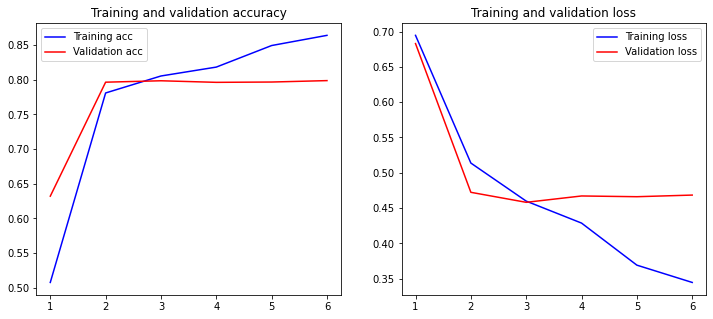

In [ ]:
#plotting the training Accuracy and Loss
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

In [ ]:
def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_acc'])+1)

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test_l = to_categorical(np.asarray(y_test_l))

In [ ]:
y_test_l

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
pred = model.predict(pad_test)

In [ ]:
print("ROC-AUC Score", roc_auc_score(y_test_l,np.round(abs(pred))))
print("Classification Report:\n", classification_report(y_test_l, np.round(abs(pred)), target_names = ["real", "fake"]))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test_l.argmax(axis=1), y_pred = pred.argmax(axis=1)))
print("BI-LSTM Accuracy: ",accuracy_score(y_test_l,  np.round(abs(pred))))

ROC-AUC Score 0.7982185024280365
Classification Report:
               precision    recall  f1-score   support

        real       0.77      0.83      0.80      3111
        fake       0.82      0.76      0.79      3189

   micro avg       0.80      0.80      0.80      6300
   macro avg       0.80      0.80      0.80      6300
weighted avg       0.80      0.80      0.80      6300
 samples avg       0.80      0.80      0.80      6300

Confusion matrix:
 [[2594  517]
 [ 757 2432]]
BI-LSTM Accuracy:  0.7977777777777778
